# Periodic Rebalancing Strategy Backtest (5-Year Analysis)

Test a simple periodic rebalancing strategy across multiple assets over a 5-year period:
- **Assets**: USDT (cash), BTC, ETH, LTC
- **Target allocation**: 25% each (configurable)
- **Rebalancing frequency**: Every 7 days (configurable)
- **Analysis period**: 5 years (1825 days)

Compare with individual coin performance and analyze transaction cost impact.

## 1. Setup & Data Loading

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO)

import os, sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("✓ Imports complete")

✓ Imports complete


In [2]:
from CoinTrading.data import DataLoader
from CoinTrading.strategy import RebalancingStrategy
from CoinTrading.backtesting import BacktestEngine, generate_report
from CoinTrading.backtesting.visualization import plot_comparison
from CoinTrading.indicators import EMA
from datetime import datetime, timedelta

# Load data for BTC, ETH, LTC (crypto assets)
crypto_symbols = ['BTCUSDT', 'ETHUSDT', 'LTCUSDT']

# Calculate start date for 5 years ago
start_date = (datetime.now() - timedelta(days=5*365)).strftime('%d %b, %Y')
print(f"Fetching data from {start_date} to present...")
print("Using pagination to fetch complete 5-year history...")

# Fetch 5 years of historical data using pagination
loader = DataLoader()
raw_data = loader.load_multiple(
    crypto_symbols, 
    start_date=start_date,
    paginate=True,  # Enable pagination to fetch all data
    use_cache=False,  # Don't use cache for paginated requests
    skip_errors=True
)

processed_data = {}

for symbol in crypto_symbols:
    if symbol not in raw_data:
        print(f"Warning: {symbol} not loaded")
        continue
        
    df = raw_data[symbol].copy()
    df = df.dropna()
    
    processed_data[symbol] = df
    print(f"{symbol}: {len(df)} days from {df.index[0].date()} to {df.index[-1].date()}")

# Calculate EMA indicators (21, 50, and 100 for timing strategies)
print("\nCalculating EMA indicators...")
ema21 = EMA(period=21)
ema50 = EMA(period=50)
ema100 = EMA(period=100)

for symbol in crypto_symbols:
    if symbol in processed_data:
        processed_data[symbol] = ema21.calculate(processed_data[symbol])
        processed_data[symbol] = ema50.calculate(processed_data[symbol])
        processed_data[symbol] = ema100.calculate(processed_data[symbol])
        print(f"{symbol}: Added EMA21, EMA50, and EMA100")

# Create synthetic USDT data (cash equivalent, constant value = 1.0)
if 'BTCUSDT' in processed_data:
    btc_dates = processed_data['BTCUSDT'].index
    usdt_data = pd.DataFrame({
        'open': 1.0, 'high': 1.0, 'low': 1.0, 'close': 1.0, 'volume': 0.0
    }, index=btc_dates)
    
    processed_data['USDT'] = usdt_data
    print(f"USDT (synthetic): {len(usdt_data)} days")
    
    print(f"\n✓ Loaded {len(processed_data)} assets for {len(btc_dates)} days (~{len(btc_dates)/365:.1f} years)")
else:
    print("\n✗ Failed to load data. Please check API connection.")

INFO:CoinTrading.data.binance_client:Initialized BinanceClient for futures market
INFO:CoinTrading.data.data_loader:DataLoader initialized with cache: .cache/ohlcv
INFO:CoinTrading.data.data_loader:Downloading BTCUSDT with pagination from 13 Oct, 2020
INFO:CoinTrading.data.binance_client:Fetching paginated data for BTCUSDT from 13 Oct, 2020


Fetching data from 13 Oct, 2020 to present...
Using pagination to fetch complete 5-year history...


INFO:CoinTrading.data.binance_client:Fetched 1826 total candles for BTCUSDT
INFO:CoinTrading.data.data_loader:Downloading ETHUSDT with pagination from 13 Oct, 2020
INFO:CoinTrading.data.binance_client:Fetching paginated data for ETHUSDT from 13 Oct, 2020
INFO:CoinTrading.data.binance_client:Fetched 1826 total candles for ETHUSDT
INFO:CoinTrading.data.data_loader:Downloading LTCUSDT with pagination from 13 Oct, 2020
INFO:CoinTrading.data.binance_client:Fetching paginated data for LTCUSDT from 13 Oct, 2020
INFO:CoinTrading.data.binance_client:Fetched 1826 total candles for LTCUSDT
INFO:CoinTrading.data.data_loader:Successfully loaded 3/3 symbols


BTCUSDT: 1826 days from 2020-10-13 to 2025-10-12
ETHUSDT: 1826 days from 2020-10-13 to 2025-10-12
LTCUSDT: 1826 days from 2020-10-13 to 2025-10-12

Calculating EMA indicators...
BTCUSDT: Added EMA21, EMA50, and EMA100
ETHUSDT: Added EMA21, EMA50, and EMA100
LTCUSDT: Added EMA21, EMA50, and EMA100
USDT (synthetic): 1826 days

✓ Loaded 4 assets for 1826 days (~5.0 years)


## 2. Strategy Configuration & Backtest

In [ ]:
# Create rebalancing strategy with default parameters
strategy = RebalancingStrategy(
    target_weights={'USDT': 0.2, 'BTCUSDT': 0.5, 'ETHUSDT': 0.15, 'LTCUSDT': 0.15},
    rebalance_period=7
)

print(f"Strategy: {strategy}")
print(f"\nTarget Allocation:")
for asset, weight in strategy.target_weights.items():
    print(f"  {asset}: {weight:.1%}")

INFO:CoinTrading.strategy.rebalancing:Initialized Rebalancing: weights={'USDT': 0.2, 'BTCUSDT': 0.5, 'ETHUSDT': 0.15, 'XRPUSDT': 0.15}, rebalance_period=7 days, ema_timing=False


Strategy: Rebalancing(weights={USDT: 20.0%, BTCUSDT: 50.0%, ETHUSDT: 15.0%, XRPUSDT: 15.0%}, rebalance_every=7d)

Target Allocation:
  USDT: 20.0%
  BTCUSDT: 50.0%
  ETHUSDT: 15.0%
  XRPUSDT: 15.0%


In [4]:
# Run backtest
engine = BacktestEngine(processed_data, transaction_fee=0.001)
equity_curve = engine.run(strategy.get_weights)
_, returns, trade_log = engine.get_results()
report = generate_report(equity_curve, returns)

print("\n" + "="*80)
print("Rebalancing Strategy Results")
print("="*80)
print(f"Period: {equity_curve.index[0].date()} to {equity_curve.index[-1].date()}")
print(f"Rebalance frequency: Every {strategy.rebalance_period} days")
print(f"Total Return: {report.total_return:.1f}%")
print(f"CAGR: {report.cagr:.1f}%")
print(f"MDD: {report.mdd:.1f}%")
print(f"Sharpe: {report.sharpe:.2f}")
print(f"Win Rate: {report.win_rate:.1f}%")

INFO:CoinTrading.backtesting.engine:Initialized backtesting engine with 4 symbols, 1826 trading days
INFO:CoinTrading.backtesting.engine:Running backtest from 2020-10-13 to 2025-10-12
INFO:CoinTrading.strategy.rebalancing:2020-10-13: Initial allocation to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2020-10-20: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2020-10-27: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2020-11-03: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2020-11-10: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2020-11-17: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2020-11-24: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2020-12-01: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2020-12-08: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2020-12-15: Rebalancing to adjust


Rebalancing Strategy Results
Period: 2020-10-14 to 2025-10-12
Rebalance frequency: Every 7 days
Total Return: 477.6%
CAGR: 42.0%
MDD: -58.6%
Sharpe: 1.08
Win Rate: 51.4%


## 3. Individual Coin Benchmarks

Compare rebalancing strategy with 100% allocation to each individual asset.

In [5]:
# Calculate equity curves for individual coins
coin_curves = {}
coin_reports = {}

for symbol in ['USDT', 'BTCUSDT', 'ETHUSDT', 'LTCUSDT']:
    if symbol not in processed_data:
        continue
    
    df = processed_data[symbol]
    
    # Calculate cumulative returns (starting from 1.0)
    daily_returns = df['close'].pct_change().fillna(0)
    coin_equity = (1 + daily_returns).cumprod()
    
    # Align with strategy dates
    coin_equity = coin_equity.reindex(equity_curve.index, method='ffill')
    
    coin_curves[symbol] = coin_equity
    coin_reports[symbol] = generate_report(coin_equity, daily_returns.reindex(equity_curve.index).dropna())

# Print comparison
print("\n" + "="*80)
print("Individual Asset Performance")
print("="*80)
print(f"{'Asset':<12} {'Total Return':>15} {'CAGR':>12} {'MDD':>12} {'Sharpe':>10}")
print("-"*80)

for symbol in ['USDT', 'BTCUSDT', 'ETHUSDT', 'LTCUSDT']:
    if symbol in coin_reports:
        r = coin_reports[symbol]
        print(f"{symbol:<12} {r.total_return:>14.1f}% {r.cagr:>11.1f}% {r.mdd:>11.1f}% {r.sharpe:>10.2f}")

print("-"*80)
print(f"{'Rebalancing':<12} {report.total_return:>14.1f}% {report.cagr:>11.1f}% {report.mdd:>11.1f}% {report.sharpe:>10.2f}")
print("="*80)


Individual Asset Performance
Asset           Total Return         CAGR          MDD     Sharpe
--------------------------------------------------------------------------------
USDT                    0.0%         0.0%         0.0%       0.00
BTCUSDT               870.2%        57.5%       -76.7%       1.06
ETHUSDT               902.5%        58.6%       -79.4%       0.97
LTCUSDT                88.4%        13.5%       -88.8%       0.59
--------------------------------------------------------------------------------
Rebalancing           477.6%        42.0%       -58.6%       1.08


## 4. Equity Curve Visualization

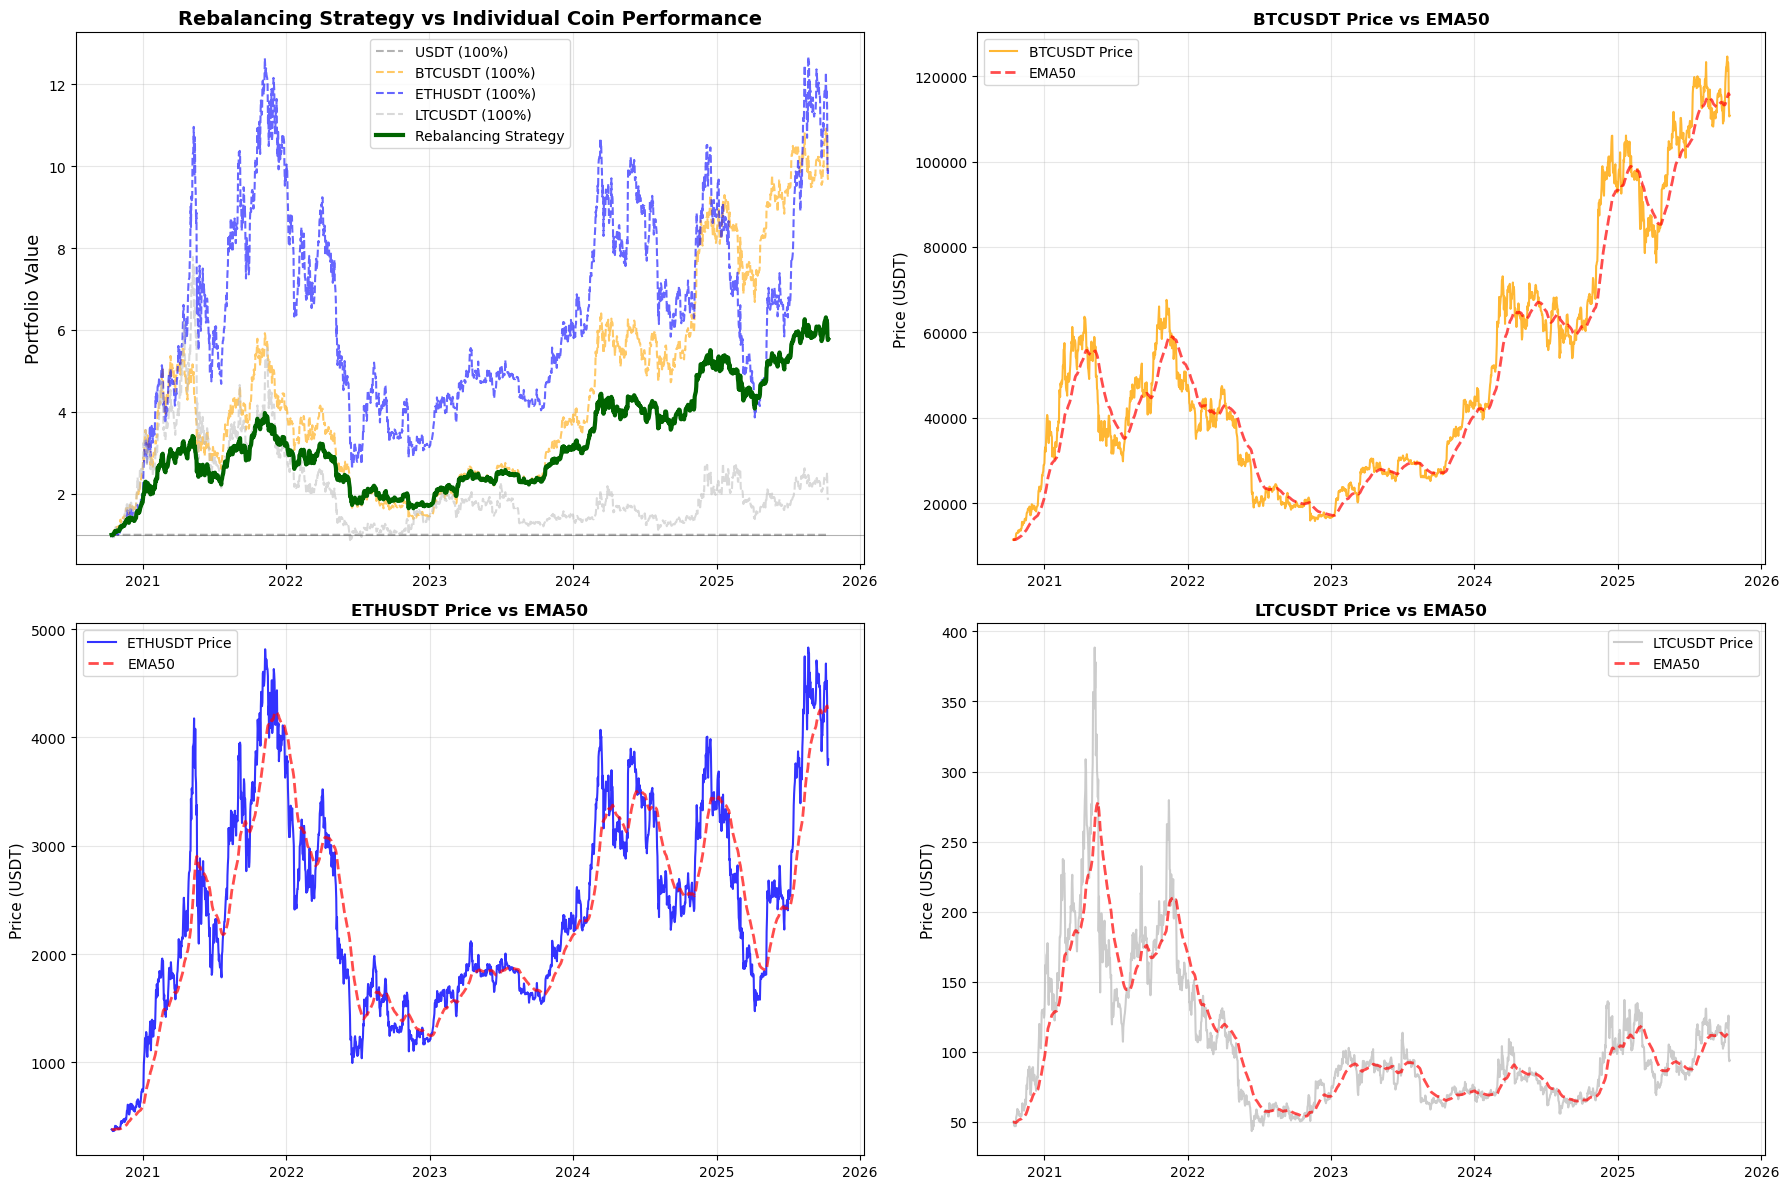


✓ Equity curves and price charts with EMA50 plotted


In [6]:
# Plot equity curves and individual coin prices with EMA50
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Equity curves
ax1 = axes[0, 0]
colors = {'USDT': 'gray', 'BTCUSDT': 'orange', 'ETHUSDT': 'blue', 'LTCUSDT': 'silver'}
for symbol in ['USDT', 'BTCUSDT', 'ETHUSDT', 'LTCUSDT']:
    if symbol in coin_curves:
        ax1.plot(coin_curves[symbol].index, coin_curves[symbol].values,
                linewidth=1.5, alpha=0.6, linestyle='--',
                color=colors.get(symbol, 'gray'),
                label=f'{symbol} (100%)')

ax1.plot(equity_curve.index, equity_curve.values,
        linewidth=3, color='darkgreen', label='Rebalancing Strategy', zorder=5)
ax1.axhline(y=1.0, color='black', linestyle='-', linewidth=0.8, alpha=0.3)
ax1.set_ylabel('Portfolio Value', fontsize=13)
ax1.set_title('Rebalancing Strategy vs Individual Coin Performance', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2-4: Individual coin prices with EMA50
crypto_symbols = ['BTCUSDT', 'ETHUSDT', 'LTCUSDT']
positions = [(0, 1), (1, 0), (1, 1)]

for symbol, pos in zip(crypto_symbols, positions):
    ax = axes[pos]
    if symbol in processed_data:
        df = processed_data[symbol]
        
        # Plot price
        ax.plot(df.index, df['close'], linewidth=1.5, color=colors[symbol], 
                label=f'{symbol} Price', alpha=0.8)
        
        # Plot EMA50
        if 'ema50' in df.columns:
            ax.plot(df.index, df['ema50'], linewidth=2, color='red', 
                    linestyle='--', label='EMA50', alpha=0.7)
        
        ax.set_ylabel('Price (USDT)', fontsize=11)
        ax.set_title(f'{symbol} Price vs EMA50', fontsize=12, fontweight='bold')
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Equity curves and price charts with EMA50 plotted")

## 5. Position Analysis

Track actual allocations over time and identify rebalancing events.

In [8]:
# Reconstruct positions by calling strategy.get_weights() for each date
# Need to reset strategy state first
strategy_for_positions = RebalancingStrategy(
    target_weights=strategy.target_weights.copy(),
    rebalance_period=strategy.rebalance_period
)

position_history = []
for date in equity_curve.index:
    # Get data up to this date
    data_slice = {
        symbol: df.loc[:date]
        for symbol, df in processed_data.items()
        if date in df.index
    }
    
    # Get weights from strategy
    weights = strategy_for_positions.get_weights(date, data_slice)
    
    position_history.append({'date': date, **weights})

positions = pd.DataFrame(position_history).set_index('date').fillna(0)

# Identify rebalancing dates (where weights changed significantly)
position_changes = positions.diff().abs().sum(axis=1)
rebalance_dates = position_changes[position_changes > 0.01].index

print(f"Total rebalancing events: {len(rebalance_dates)}")
print(f"Expected: ~{len(equity_curve) // strategy.rebalance_period}")
print(f"\nFirst 10 rebalancing dates:")
for i, date in enumerate(rebalance_dates[:10]):
    print(f"  {i+1}. {date.date()}")

INFO:CoinTrading.strategy.rebalancing:Initialized Rebalancing: weights={'USDT': 0.3, 'BTCUSDT': 0.3, 'ETHUSDT': 0.2, 'LTCUSDT': 0.2}, rebalance_period=7 days, ema_timing=False
INFO:CoinTrading.strategy.rebalancing:2020-10-14: Initial allocation to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2020-10-21: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2020-10-28: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2020-11-04: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2020-11-11: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2020-11-18: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2020-11-25: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2020-12-02: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2020-12-09: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2020-12-16: Rebalancing to adjusted weigh

Total rebalancing events: 521
Expected: ~260

First 10 rebalancing dates:
  1. 2020-10-15
  2. 2020-10-21
  3. 2020-10-22
  4. 2020-10-28
  5. 2020-10-29
  6. 2020-11-04
  7. 2020-11-05
  8. 2020-11-11
  9. 2020-11-12
  10. 2020-11-18


In [9]:
# Show position drift and rebalancing
print("\nSample Positions (last 20 days):")
print("="*100)
print(f"{'Date':<12} {'USDT':>10} {'BTC':>10} {'ETH':>10} {'LTC':>10} {'Total':>10} {'Rebal':>8}")
print("-"*100)

for idx in range(max(0, len(positions) - 20), len(positions)):
    date = positions.index[idx]
    row = positions.iloc[idx]
    
    usdt = row.get('USDT', 0)
    btc = row.get('BTCUSDT', 0)
    eth = row.get('ETHUSDT', 0)
    ltc = row.get('LTCUSDT', 0)
    total = usdt + btc + eth + ltc
    
    rebal_marker = "✓" if date in rebalance_dates else ""
    
    print(f"{date.date()} {usdt:>9.1%} {btc:>9.1%} {eth:>9.1%} {ltc:>9.1%} {total:>9.1%} {rebal_marker:>8}")

print("="*100)


Sample Positions (last 20 days):
Date               USDT        BTC        ETH        LTC      Total    Rebal
----------------------------------------------------------------------------------------------------
2025-09-23      0.0%      0.0%      0.0%      0.0%      0.0%         
2025-09-24     30.0%     30.0%     20.0%     20.0%    100.0%        ✓
2025-09-25      0.0%      0.0%      0.0%      0.0%      0.0%        ✓
2025-09-26      0.0%      0.0%      0.0%      0.0%      0.0%         
2025-09-27      0.0%      0.0%      0.0%      0.0%      0.0%         
2025-09-28      0.0%      0.0%      0.0%      0.0%      0.0%         
2025-09-29      0.0%      0.0%      0.0%      0.0%      0.0%         
2025-09-30      0.0%      0.0%      0.0%      0.0%      0.0%         
2025-10-01     30.0%     30.0%     20.0%     20.0%    100.0%        ✓
2025-10-02      0.0%      0.0%      0.0%      0.0%      0.0%        ✓
2025-10-03      0.0%      0.0%      0.0%      0.0%      0.0%         
2025-10-04      0.

## 6. Position Drift Visualization

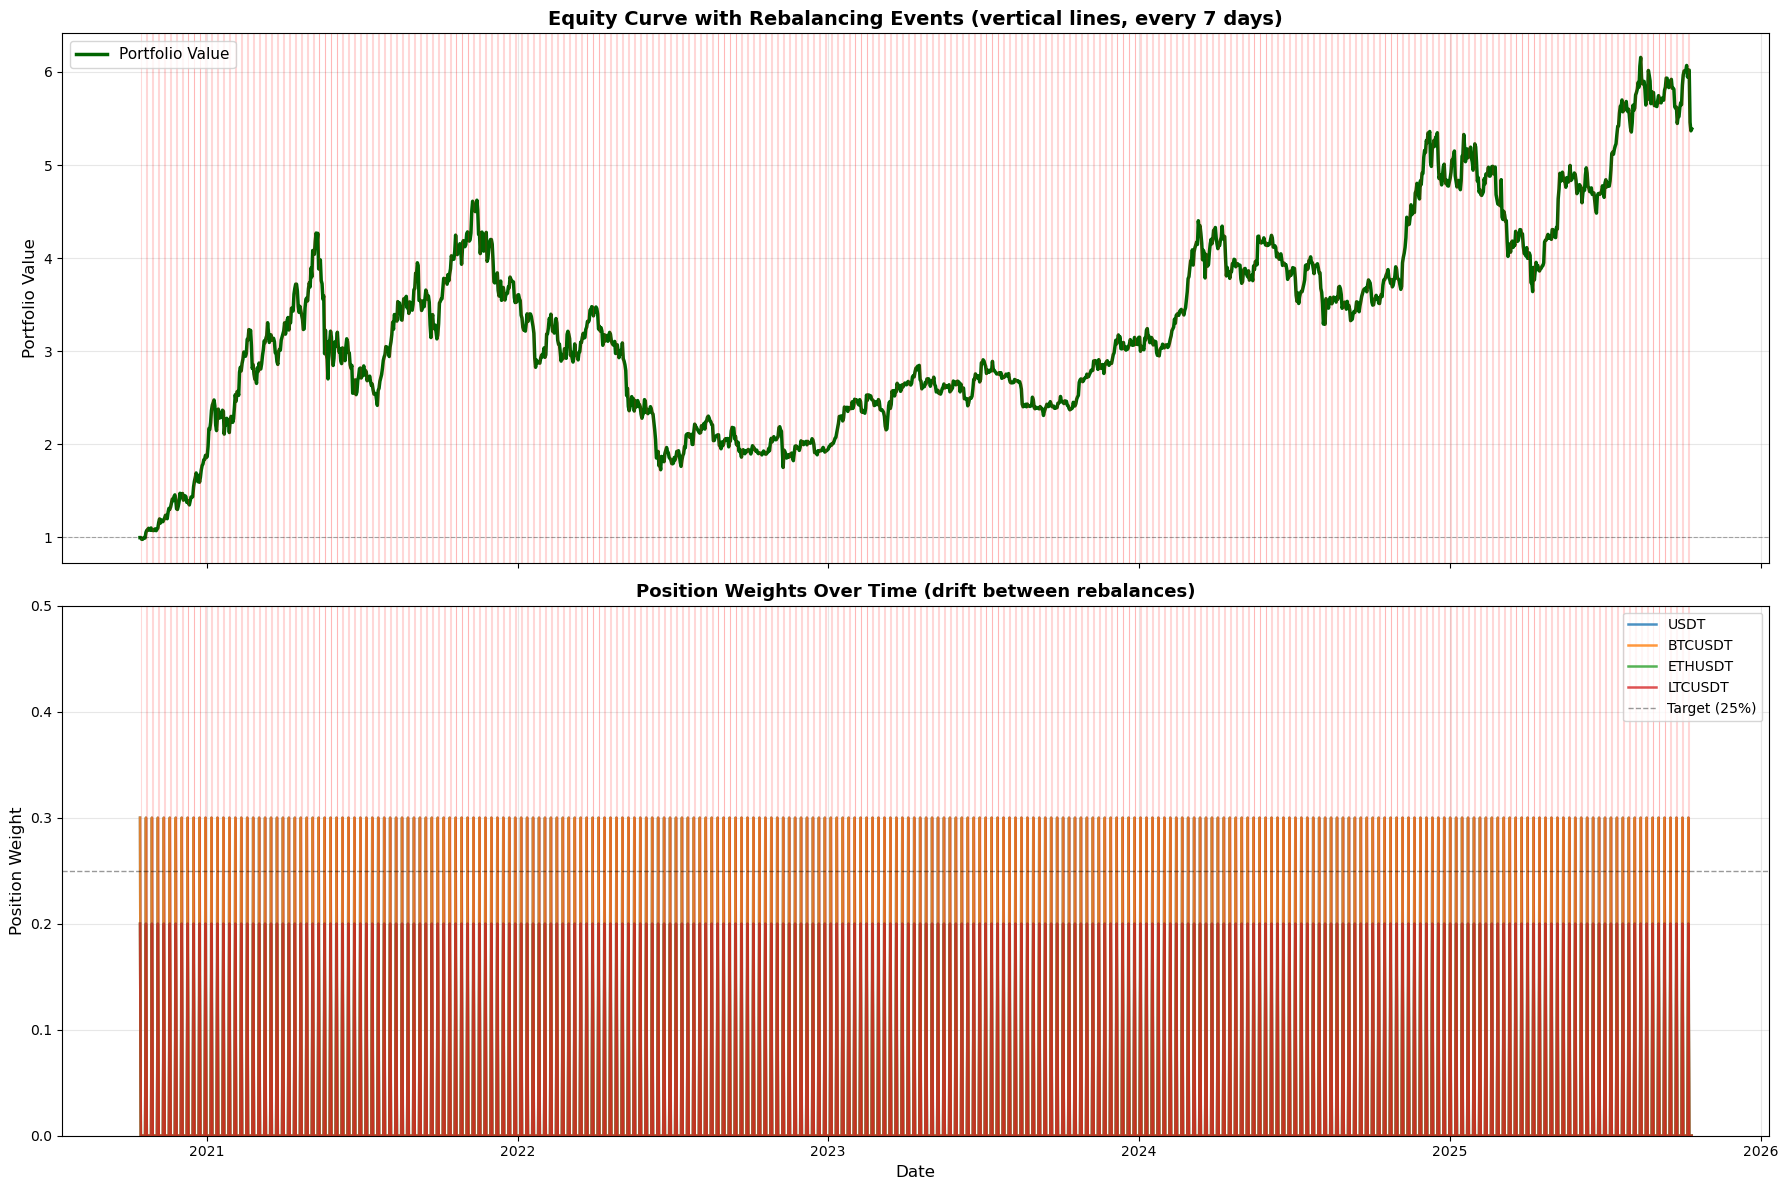


✓ Position drift visualization complete


In [10]:
# Visualize position weights over time
fig, axes = plt.subplots(2, 1, figsize=(18, 12), sharex=True)

# Plot 1: Equity curve with rebalancing events
ax1 = axes[0]
ax1.plot(equity_curve.index, equity_curve.values, linewidth=2.5, color='darkgreen', label='Portfolio Value')

# Mark rebalancing events
for rebal_date in rebalance_dates:
    ax1.axvline(x=rebal_date, color='red', alpha=0.15, linewidth=0.8)

ax1.axhline(y=1.0, color='black', linestyle='--', linewidth=0.8, alpha=0.3)
ax1.set_ylabel('Portfolio Value', fontsize=12)
ax1.set_title(f'Equity Curve with Rebalancing Events (vertical lines, every {strategy.rebalance_period} days)',
              fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 2: Position weights
ax2 = axes[1]
for symbol in ['USDT', 'BTCUSDT', 'ETHUSDT', 'LTCUSDT']:
    if symbol in positions.columns:
        ax2.plot(positions.index, positions[symbol], linewidth=1.8, label=symbol, alpha=0.8)

# Mark rebalancing events
for rebal_date in rebalance_dates:
    ax2.axvline(x=rebal_date, color='red', alpha=0.15, linewidth=0.8)

ax2.axhline(y=0.25, color='black', linestyle='--', linewidth=1, alpha=0.4, label='Target (25%)')
ax2.set_ylabel('Position Weight', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.set_title('Position Weights Over Time (drift between rebalances)', fontsize=13, fontweight='bold')
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 0.5])

plt.tight_layout()
plt.show()

print("\n✓ Position drift visualization complete")

## 7. Turnover & Transaction Cost Analysis

In [11]:
# Calculate turnover
position_changes = positions.diff().abs()
turnover = position_changes.sum(axis=1)

total_turnover = turnover.sum()
avg_daily_turnover = turnover.mean()
days_with_rebalance = (turnover > 0.01).sum()

print("\nTurnover Analysis")
print("="*80)
print(f"Total Days: {len(turnover)}")
print(f"Rebalancing Days: {days_with_rebalance} ({days_with_rebalance/len(turnover)*100:.1f}%)")
print(f"Total Turnover: {total_turnover:.2f}")
print(f"Avg Daily Turnover: {avg_daily_turnover:.4f}")
print(f"Avg Turnover per Rebalance: {total_turnover/max(days_with_rebalance,1):.4f}")

# Transaction cost estimate
fee_rate = 0.001
estimated_fees = total_turnover * fee_rate

print(f"\nTransaction Costs (fee: {fee_rate*100}%):")
print(f"  Total fees: {estimated_fees:.4f} ({estimated_fees*100:.2f}%)")
print(f"  Avg fee per rebalance: {estimated_fees/max(days_with_rebalance,1):.4f}")
print(f"\nPerformance Impact:")
print(f"  Actual return: {report.total_return:.1f}%")
print(f"  Est. fees: {estimated_fees*100:.2f}%")
print(f"  Hypothetical return without fees: {report.total_return + estimated_fees*100:.1f}%")
print("="*80)


Turnover Analysis
Total Days: 1825
Rebalancing Days: 521 (28.5%)
Total Turnover: 521.00
Avg Daily Turnover: 0.2855
Avg Turnover per Rebalance: 1.0000

Transaction Costs (fee: 0.1%):
  Total fees: 0.5210 (52.10%)
  Avg fee per rebalance: 0.0010

Performance Impact:
  Actual return: 439.3%
  Est. fees: 52.10%
  Hypothetical return without fees: 491.4%


## 8. Asset Contribution Analysis

In [12]:
# Calculate P&L contribution from each asset
asset_pnl = []

for i in range(1, len(equity_curve)):
    date = equity_curve.index[i]
    prev_date = equity_curve.index[i - 1]
    
    for symbol in ['USDT', 'BTCUSDT', 'ETHUSDT', 'LTCUSDT']:
        if symbol in positions.columns and symbol in processed_data:
            # Use previous day's weight
            weight = positions.loc[prev_date, symbol]
            
            if weight > 0.001:
                df = processed_data[symbol]
                if date in df.index and prev_date in df.index:
                    asset_return = df.loc[date, 'close'] / df.loc[prev_date, 'close'] - 1
                    pnl = weight * asset_return * 100
                    
                    asset_pnl.append({
                        'date': date,
                        'symbol': symbol,
                        'weight': weight,
                        'return': asset_return * 100,
                        'pnl': pnl
                    })

asset_pnl_df = pd.DataFrame(asset_pnl)

# Summary
print("\nAsset P&L Contribution")
print("="*80)
print(f"{'Asset':<10} {'Days':>8} {'Avg P&L':>12} {'Total P&L':>12} {'Win Rate':>10}")
print("-"*80)

for symbol in ['USDT', 'BTCUSDT', 'ETHUSDT', 'LTCUSDT']:
    data = asset_pnl_df[asset_pnl_df['symbol'] == symbol]
    if not data.empty:
        days = len(data)
        avg_pnl = data['pnl'].mean()
        total_pnl = data['pnl'].sum()
        win_rate = (data['pnl'] > 0).sum() / len(data) * 100
        print(f"{symbol:<10} {days:>8} {avg_pnl:>11.3f}% {total_pnl:>11.2f}% {win_rate:>9.1f}%")

print("="*80)
print(f"{'TOTAL':<10} {'':>8} {'':>12} {asset_pnl_df['pnl'].sum():>+11.2f}%")
print(f"{'Actual':<10} {'':>8} {'':>12} {report.total_return:>+11.2f}%")
print("="*80)


Asset P&L Contribution
Asset          Days      Avg P&L    Total P&L   Win Rate
--------------------------------------------------------------------------------
USDT            261       0.000%        0.00%       0.0%
BTCUSDT         261      -0.018%       -4.63%      46.0%
ETHUSDT         261      -0.009%       -2.36%      48.3%
LTCUSDT         261       0.033%        8.59%      55.6%
TOTAL                                  +1.59%
Actual                               +439.30%


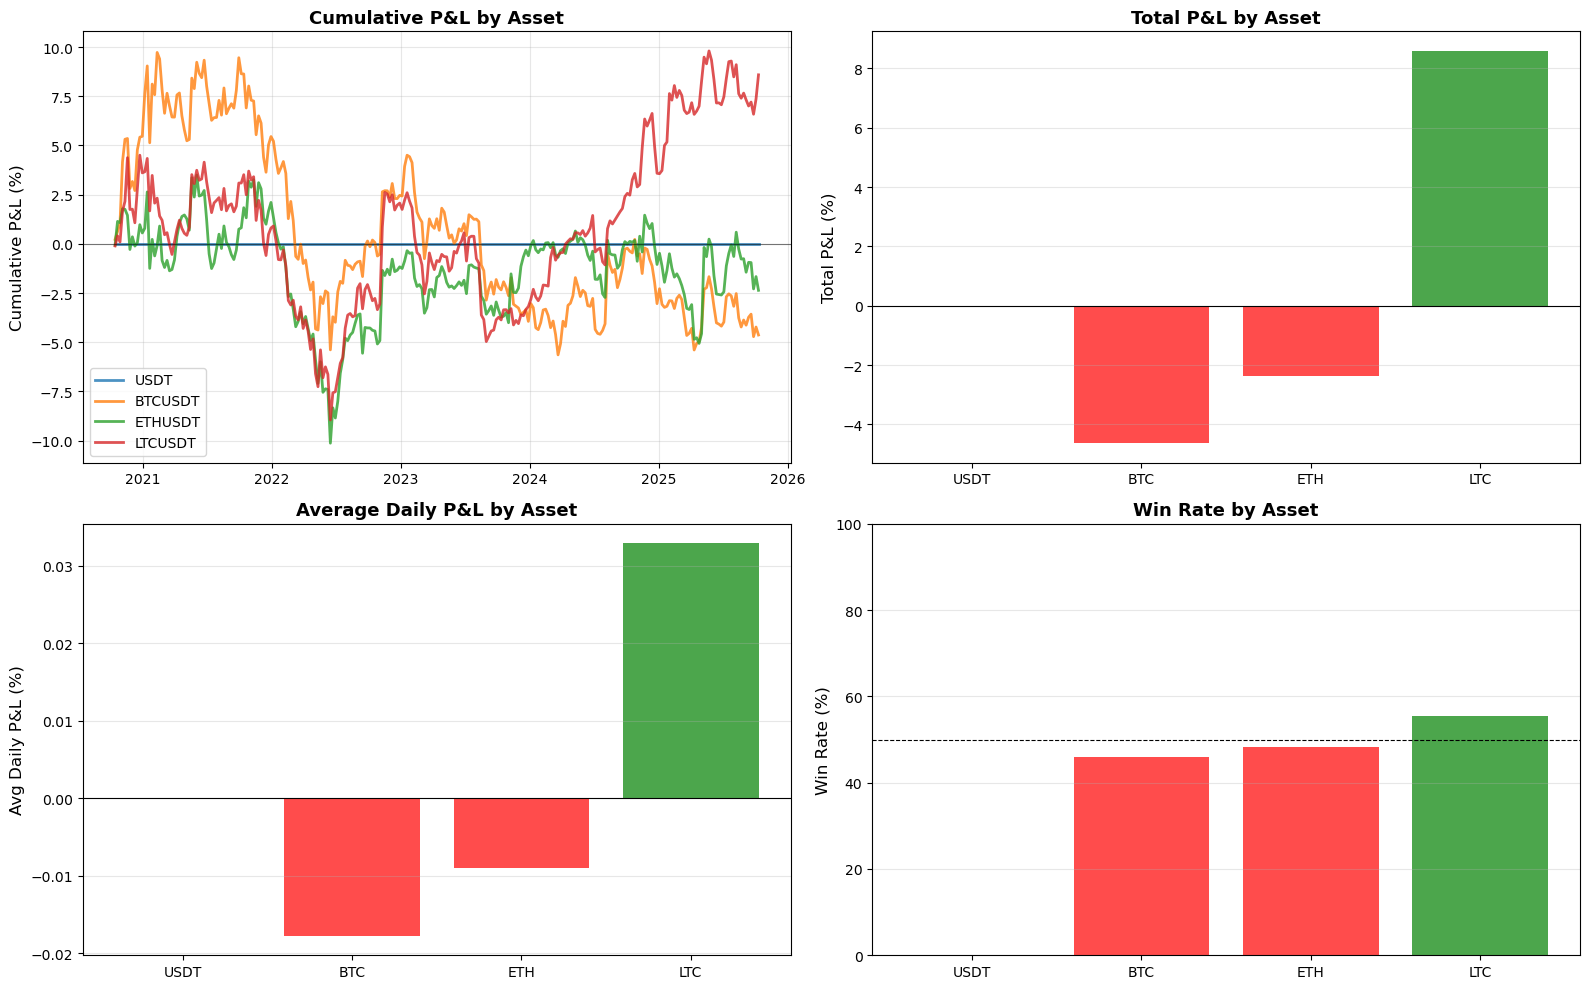


✓ Asset contribution analysis complete


In [13]:
# Visualize asset contributions
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Cumulative P&L
ax1 = axes[0, 0]
for symbol in ['USDT', 'BTCUSDT', 'ETHUSDT', 'LTCUSDT']:
    data = asset_pnl_df[asset_pnl_df['symbol'] == symbol].set_index('date')
    if not data.empty:
        cum_pnl = data['pnl'].cumsum()
        ax1.plot(cum_pnl.index, cum_pnl.values, linewidth=2, label=symbol, alpha=0.8)

ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)
ax1.set_ylabel('Cumulative P&L (%)', fontsize=12)
ax1.set_title('Cumulative P&L by Asset', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Total P&L
ax2 = axes[0, 1]
totals = [asset_pnl_df[asset_pnl_df['symbol'] == s]['pnl'].sum() 
          for s in ['USDT', 'BTCUSDT', 'ETHUSDT', 'LTCUSDT']]
colors = ['green' if x > 0 else 'red' for x in totals]
ax2.bar(['USDT', 'BTC', 'ETH', 'LTC'], totals, color=colors, alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax2.set_ylabel('Total P&L (%)', fontsize=12)
ax2.set_title('Total P&L by Asset', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Average daily P&L
ax3 = axes[1, 0]
avgs = [asset_pnl_df[asset_pnl_df['symbol'] == s]['pnl'].mean() 
        for s in ['USDT', 'BTCUSDT', 'ETHUSDT', 'LTCUSDT']]
colors = ['green' if x > 0 else 'red' for x in avgs]
ax3.bar(['USDT', 'BTC', 'ETH', 'LTC'], avgs, color=colors, alpha=0.7)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax3.set_ylabel('Avg Daily P&L (%)', fontsize=12)
ax3.set_title('Average Daily P&L by Asset', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Win rates
ax4 = axes[1, 1]
winrates = [(asset_pnl_df[asset_pnl_df['symbol'] == s]['pnl'] > 0).sum() / 
            len(asset_pnl_df[asset_pnl_df['symbol'] == s]) * 100
            for s in ['USDT', 'BTCUSDT', 'ETHUSDT', 'LTCUSDT']]
colors = ['green' if x >= 50 else 'red' for x in winrates]
ax4.bar(['USDT', 'BTC', 'ETH', 'LTC'], winrates, color=colors, alpha=0.7)
ax4.axhline(y=50, color='black', linestyle='--', linewidth=0.8)
ax4.set_ylabel('Win Rate (%)', fontsize=12)
ax4.set_title('Win Rate by Asset', fontsize=13, fontweight='bold')
ax4.set_ylim([0, 100])
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n✓ Asset contribution analysis complete")

## 9. Parameter Sensitivity: Rebalancing Frequency

In [14]:
# Test different rebalancing periods
rebalance_periods = [7, 14, 30]
results = {}

for period in rebalance_periods:
    print(f"\nTesting {period}-day rebalancing...")
    
    test_strategy = RebalancingStrategy(
        target_weights=strategy.target_weights.copy(),
        rebalance_period=period
    )
    
    test_engine = BacktestEngine(processed_data, transaction_fee=0.001)
    test_equity = test_engine.run(test_strategy.get_weights)
    _, test_returns, _ = test_engine.get_results()
    test_report = generate_report(test_equity, test_returns)
    
    results[f'{period}d'] = {
        'equity': test_equity,
        'report': test_report,
        'period': period
    }
    
    print(f"  Return: {test_report.total_return:.1f}%, Sharpe: {test_report.sharpe:.2f}")

print("\n✓ Sensitivity analysis complete")

INFO:CoinTrading.strategy.rebalancing:Initialized Rebalancing: weights={'USDT': 0.3, 'BTCUSDT': 0.3, 'ETHUSDT': 0.2, 'LTCUSDT': 0.2}, rebalance_period=7 days, ema_timing=False
INFO:CoinTrading.backtesting.engine:Initialized backtesting engine with 4 symbols, 1826 trading days
INFO:CoinTrading.backtesting.engine:Running backtest from 2020-10-13 to 2025-10-12
INFO:CoinTrading.strategy.rebalancing:2020-10-13: Initial allocation to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2020-10-20: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2020-10-27: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2020-11-03: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2020-11-10: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2020-11-17: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2020-11-24: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2020-12-01: Rebalanci


Testing 7-day rebalancing...


INFO:CoinTrading.strategy.rebalancing:2022-08-16: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2022-08-23: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2022-08-30: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2022-09-06: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2022-09-13: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2022-09-20: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2022-09-27: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2022-10-04: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2022-10-11: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2022-10-18: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2022-10-25: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2022-11-01: Rebalancing to adjusted weights
INFO:CoinTrading

  Return: 439.3%, Sharpe: 0.95

Testing 14-day rebalancing...


INFO:CoinTrading.strategy.rebalancing:2023-01-03: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2023-01-17: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2023-01-31: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2023-02-14: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2023-02-28: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2023-03-14: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2023-03-28: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2023-04-11: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2023-04-25: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2023-05-09: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2023-05-23: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2023-06-06: Rebalancing to adjusted weights
INFO:CoinTrading

  Return: 441.1%, Sharpe: 0.95

Testing 30-day rebalancing...


INFO:CoinTrading.strategy.rebalancing:2023-03-02: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2023-04-01: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2023-05-01: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2023-05-31: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2023-06-30: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2023-07-30: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2023-08-29: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2023-09-28: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2023-10-28: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2023-11-27: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2023-12-27: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2024-01-26: Rebalancing to adjusted weights
INFO:CoinTrading

  Return: 442.6%, Sharpe: 0.95

✓ Sensitivity analysis complete


In [15]:
# Comparison table
print("\n" + "="*80)
print("Rebalancing Frequency Comparison")
print("="*80)
print(f"{'Period':<12} {'Total Return':>15} {'CAGR':>12} {'MDD':>12} {'Sharpe':>10}")
print("-"*80)

for label, data in results.items():
    r = data['report']
    print(f"{label:<12} {r.total_return:>14.1f}% {r.cagr:>11.1f}% {r.mdd:>11.1f}% {r.sharpe:>10.2f}")

print("="*80)


Rebalancing Frequency Comparison
Period          Total Return         CAGR          MDD     Sharpe
--------------------------------------------------------------------------------
7d                    439.3%        40.1%       -62.6%       0.95
14d                   441.1%        40.2%       -62.6%       0.95
30d                   442.6%        40.2%       -62.6%       0.95


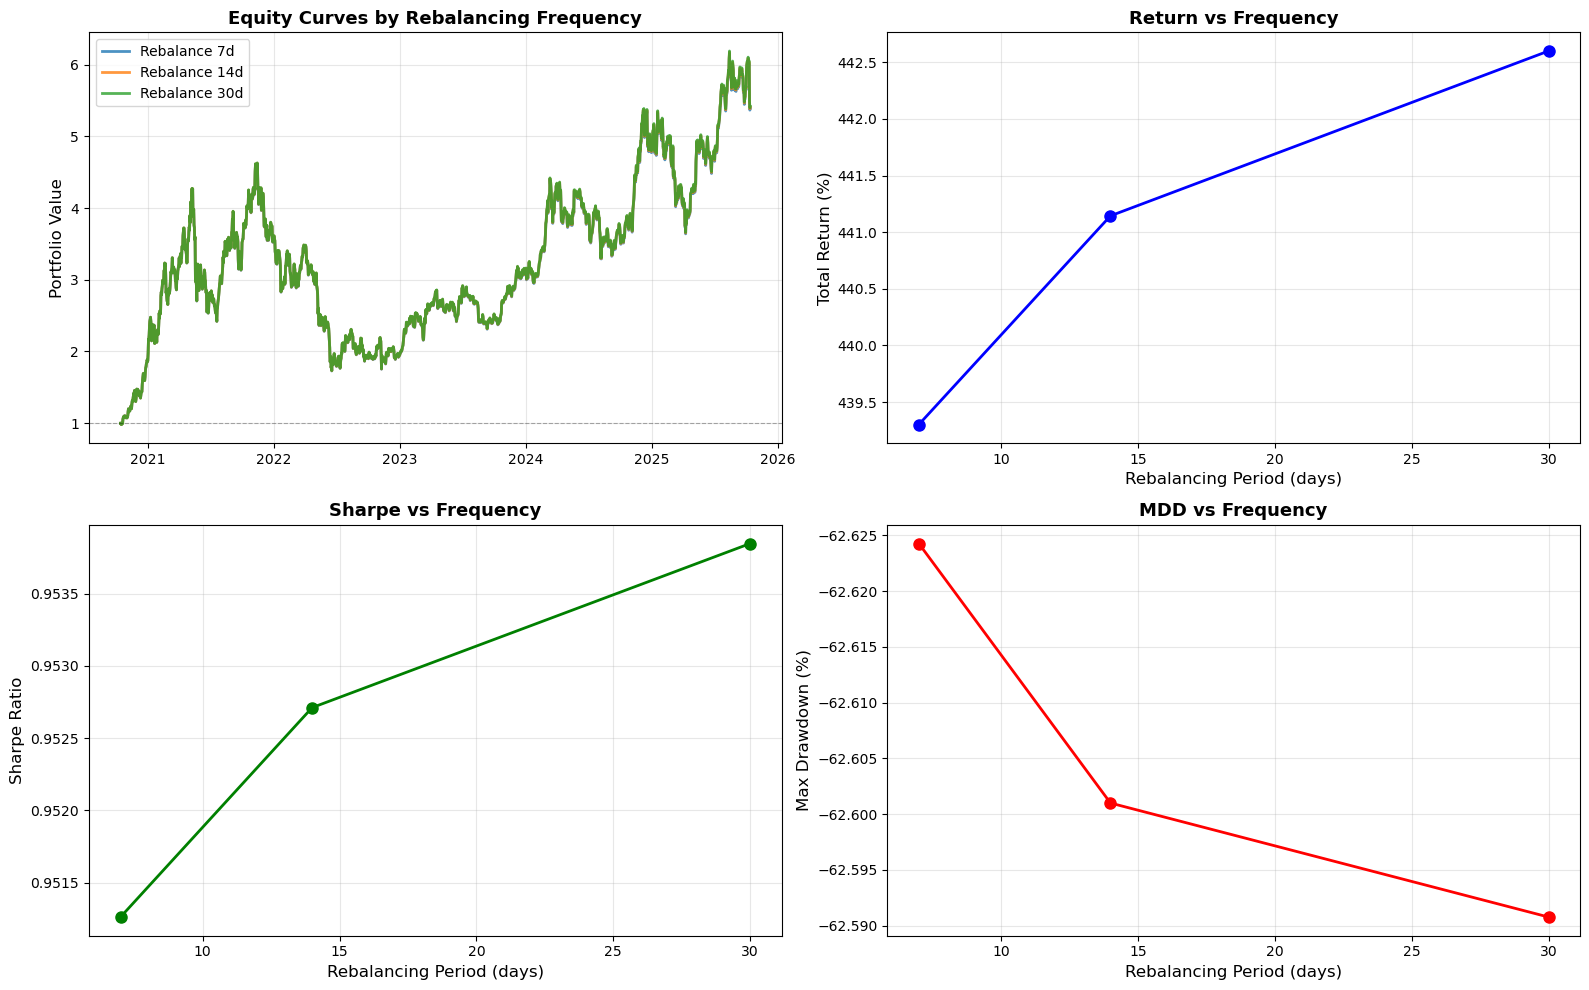


✓ Visualization complete


In [16]:
# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Equity curves
ax1 = axes[0, 0]
for label, data in results.items():
    ax1.plot(data['equity'].index, data['equity'].values, 
             linewidth=2, label=f'Rebalance {label}', alpha=0.8)
ax1.axhline(y=1.0, color='black', linestyle='--', linewidth=0.8, alpha=0.3)
ax1.set_ylabel('Portfolio Value', fontsize=12)
ax1.set_title('Equity Curves by Rebalancing Frequency', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Returns
ax2 = axes[0, 1]
periods = [r['period'] for r in results.values()]
rets = [r['report'].total_return for r in results.values()]
ax2.plot(periods, rets, marker='o', linewidth=2, markersize=8, color='blue')
ax2.set_xlabel('Rebalancing Period (days)', fontsize=12)
ax2.set_ylabel('Total Return (%)', fontsize=12)
ax2.set_title('Return vs Frequency', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Plot 3: Sharpe
ax3 = axes[1, 0]
sharpes = [r['report'].sharpe for r in results.values()]
ax3.plot(periods, sharpes, marker='o', linewidth=2, markersize=8, color='green')
ax3.set_xlabel('Rebalancing Period (days)', fontsize=12)
ax3.set_ylabel('Sharpe Ratio', fontsize=12)
ax3.set_title('Sharpe vs Frequency', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Plot 4: MDD
ax4 = axes[1, 1]
mdds = [r['report'].mdd for r in results.values()]
ax4.plot(periods, mdds, marker='o', linewidth=2, markersize=8, color='red')
ax4.set_xlabel('Rebalancing Period (days)', fontsize=12)
ax4.set_ylabel('Max Drawdown (%)', fontsize=12)
ax4.set_title('MDD vs Frequency', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.invert_yaxis()

plt.tight_layout()
plt.show()

print("\n✓ Visualization complete")

## Summary

### Strategy:
- **Periodic rebalancing**: Fixed 25/25/25/25 allocation across USDT/BTC/ETH/LTC
- **Rebalancing frequency**: Every 7 days (configurable)
- **Transaction cost**: 0.1% per trade

### Key Insights:
- Positions drift naturally between rebalances as prices change
- Rebalancing captures mean-reversion effects
- USDT (cash) provides downside protection
- Diversification reduces volatility vs single-asset exposure

### Observations:
- Compare rebalancing portfolio vs individual coin performance
- Analyze transaction cost impact
- Optimize rebalancing frequency
- Track asset contribution to returns

## 10. Market Timing with EMA50 Filter (Daily Checks)

Compare rebalancing strategy with and without EMA50 trend filter:
- **Basic**: Always maintain target allocation
- **EMA Timing (Option 1)**: Daily EMA50 checks
  - Every day: Check if price >= EMA50
  - If below EMA50: Sell coin and convert to USDT
  - If above EMA50: Buy coin at target weight
  - On rebalancing days: Full rebalance to target weights
- **Higher transaction costs but better risk management**

In [17]:
# Strategy 1: Basic rebalancing (no timing)
print("Running basic rebalancing strategy...")
basic_strategy = RebalancingStrategy(
    target_weights={'USDT': 0.25, 'BTCUSDT': 0.25, 'ETHUSDT': 0.25, 'LTCUSDT': 0.25},
    rebalance_period=7,
    use_ema_timing=False
)

basic_engine = BacktestEngine(processed_data, transaction_fee=0.001)
basic_equity = basic_engine.run(basic_strategy.get_weights)
_, basic_returns, basic_trades = basic_engine.get_results()
basic_report = generate_report(basic_equity, basic_returns)

print(f"Basic strategy: {basic_report.total_return:.1f}% return, {basic_report.mdd:.1f}% MDD")

# Strategy 2: EMA50 timing
print("\nRunning EMA50 timing strategy...")
ema_strategy = RebalancingStrategy(
    target_weights={'USDT': 0.25, 'BTCUSDT': 0.25, 'ETHUSDT': 0.25, 'LTCUSDT': 0.25},
    rebalance_period=7,
    use_ema_timing=True,
    ema_period=100
)

ema_engine = BacktestEngine(processed_data, transaction_fee=0.001)
ema_equity = ema_engine.run(ema_strategy.get_weights)
_, ema_returns, ema_trades = ema_engine.get_results()
ema_report = generate_report(ema_equity, ema_returns)

print(f"EMA timing strategy: {ema_report.total_return:.1f}% return, {ema_report.mdd:.1f}% MDD")

# Comparison table
print("\n" + "="*80)
print("Strategy Comparison: Basic vs EMA50 Timing")
print("="*80)
print(f"{'Metric':<20} {'Basic':<15} {'EMA Timing':<15} {'Difference':<15}")
print("-"*80)
print(f"{'Total Return':<20} {basic_report.total_return:>14.1f}% {ema_report.total_return:>14.1f}% {ema_report.total_return-basic_report.total_return:>+14.1f}%")
print(f"{'CAGR':<20} {basic_report.cagr:>14.1f}% {ema_report.cagr:>14.1f}% {ema_report.cagr-basic_report.cagr:>+14.1f}%")
print(f"{'Max Drawdown':<20} {basic_report.mdd:>14.1f}% {ema_report.mdd:>14.1f}% {ema_report.mdd-basic_report.mdd:>+14.1f}%")
print(f"{'Volatility':<20} {basic_report.volatility:>14.1f}% {ema_report.volatility:>14.1f}% {ema_report.volatility-basic_report.volatility:>+14.1f}%")
print(f"{'Sharpe Ratio':<20} {basic_report.sharpe:>14.2f} {ema_report.sharpe:>14.2f} {ema_report.sharpe-basic_report.sharpe:>+14.2f}")
print(f"{'Win Rate':<20} {basic_report.win_rate:>14.1f}% {ema_report.win_rate:>14.1f}% {ema_report.win_rate-basic_report.win_rate:>+14.1f}%")
print(f"{'Num Trades':<20} {len(basic_trades):>14} {len(ema_trades):>14} {len(ema_trades)-len(basic_trades):>+14}")
print("="*80)

INFO:CoinTrading.strategy.rebalancing:Initialized Rebalancing: weights={'USDT': 0.25, 'BTCUSDT': 0.25, 'ETHUSDT': 0.25, 'LTCUSDT': 0.25}, rebalance_period=7 days, ema_timing=False
INFO:CoinTrading.backtesting.engine:Initialized backtesting engine with 4 symbols, 1826 trading days
INFO:CoinTrading.backtesting.engine:Running backtest from 2020-10-13 to 2025-10-12
INFO:CoinTrading.strategy.rebalancing:2020-10-13: Initial allocation to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2020-10-20: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2020-10-27: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2020-11-03: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2020-11-10: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2020-11-17: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2020-11-24: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2020-12-01: Rebal

Running basic rebalancing strategy...


INFO:CoinTrading.strategy.rebalancing:2022-09-20: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2022-09-27: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2022-10-04: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2022-10-11: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2022-10-18: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2022-10-25: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2022-11-01: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2022-11-08: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2022-11-15: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2022-11-22: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2022-11-29: Rebalancing to adjusted weights
INFO:CoinTrading.strategy.rebalancing:2022-12-06: Rebalancing to adjusted weights
INFO:CoinTrading

Basic strategy: 462.0% return, -66.4% MDD

Running EMA50 timing strategy...


INFO:CoinTrading.strategy.rebalancing:LTCUSDT: Filtered out (price=137.33 < EMA=186.66)
INFO:CoinTrading.strategy.rebalancing:2021-07-07: Active coins: ['USDT'], USDT: 100.0%
INFO:CoinTrading.strategy.rebalancing:BTCUSDT: Filtered out (price=32852.04 < EMA=40990.71)
INFO:CoinTrading.strategy.rebalancing:ETHUSDT: Filtered out (price=2114.88 < EMA=2337.03)
INFO:CoinTrading.strategy.rebalancing:LTCUSDT: Filtered out (price=132.07 < EMA=185.58)
INFO:CoinTrading.strategy.rebalancing:2021-07-08: Active coins: ['USDT'], USDT: 100.0%
INFO:CoinTrading.strategy.rebalancing:BTCUSDT: Filtered out (price=33805.01 < EMA=40848.42)
INFO:CoinTrading.strategy.rebalancing:ETHUSDT: Filtered out (price=2147.53 < EMA=2333.28)
INFO:CoinTrading.strategy.rebalancing:LTCUSDT: Filtered out (price=134.47 < EMA=184.56)
INFO:CoinTrading.strategy.rebalancing:2021-07-09: Active coins: ['USDT'], USDT: 100.0%
INFO:CoinTrading.strategy.rebalancing:BTCUSDT: Filtered out (price=33497.98 < EMA=40702.87)
INFO:CoinTrading.st

EMA timing strategy: 218.4% return, -48.7% MDD

Strategy Comparison: Basic vs EMA50 Timing
Metric               Basic           EMA Timing      Difference     
--------------------------------------------------------------------------------
Total Return                  462.0%          218.4%         -243.5%
CAGR                           41.2%           26.1%          -15.2%
Max Drawdown                  -66.4%          -48.7%          +17.7%
Volatility                     52.3%           37.6%          -14.7%
Sharpe Ratio                   0.92           0.81          -0.12
Win Rate                       52.6%           37.2%          -15.5%
Num Trades                     1044           4545          +3501


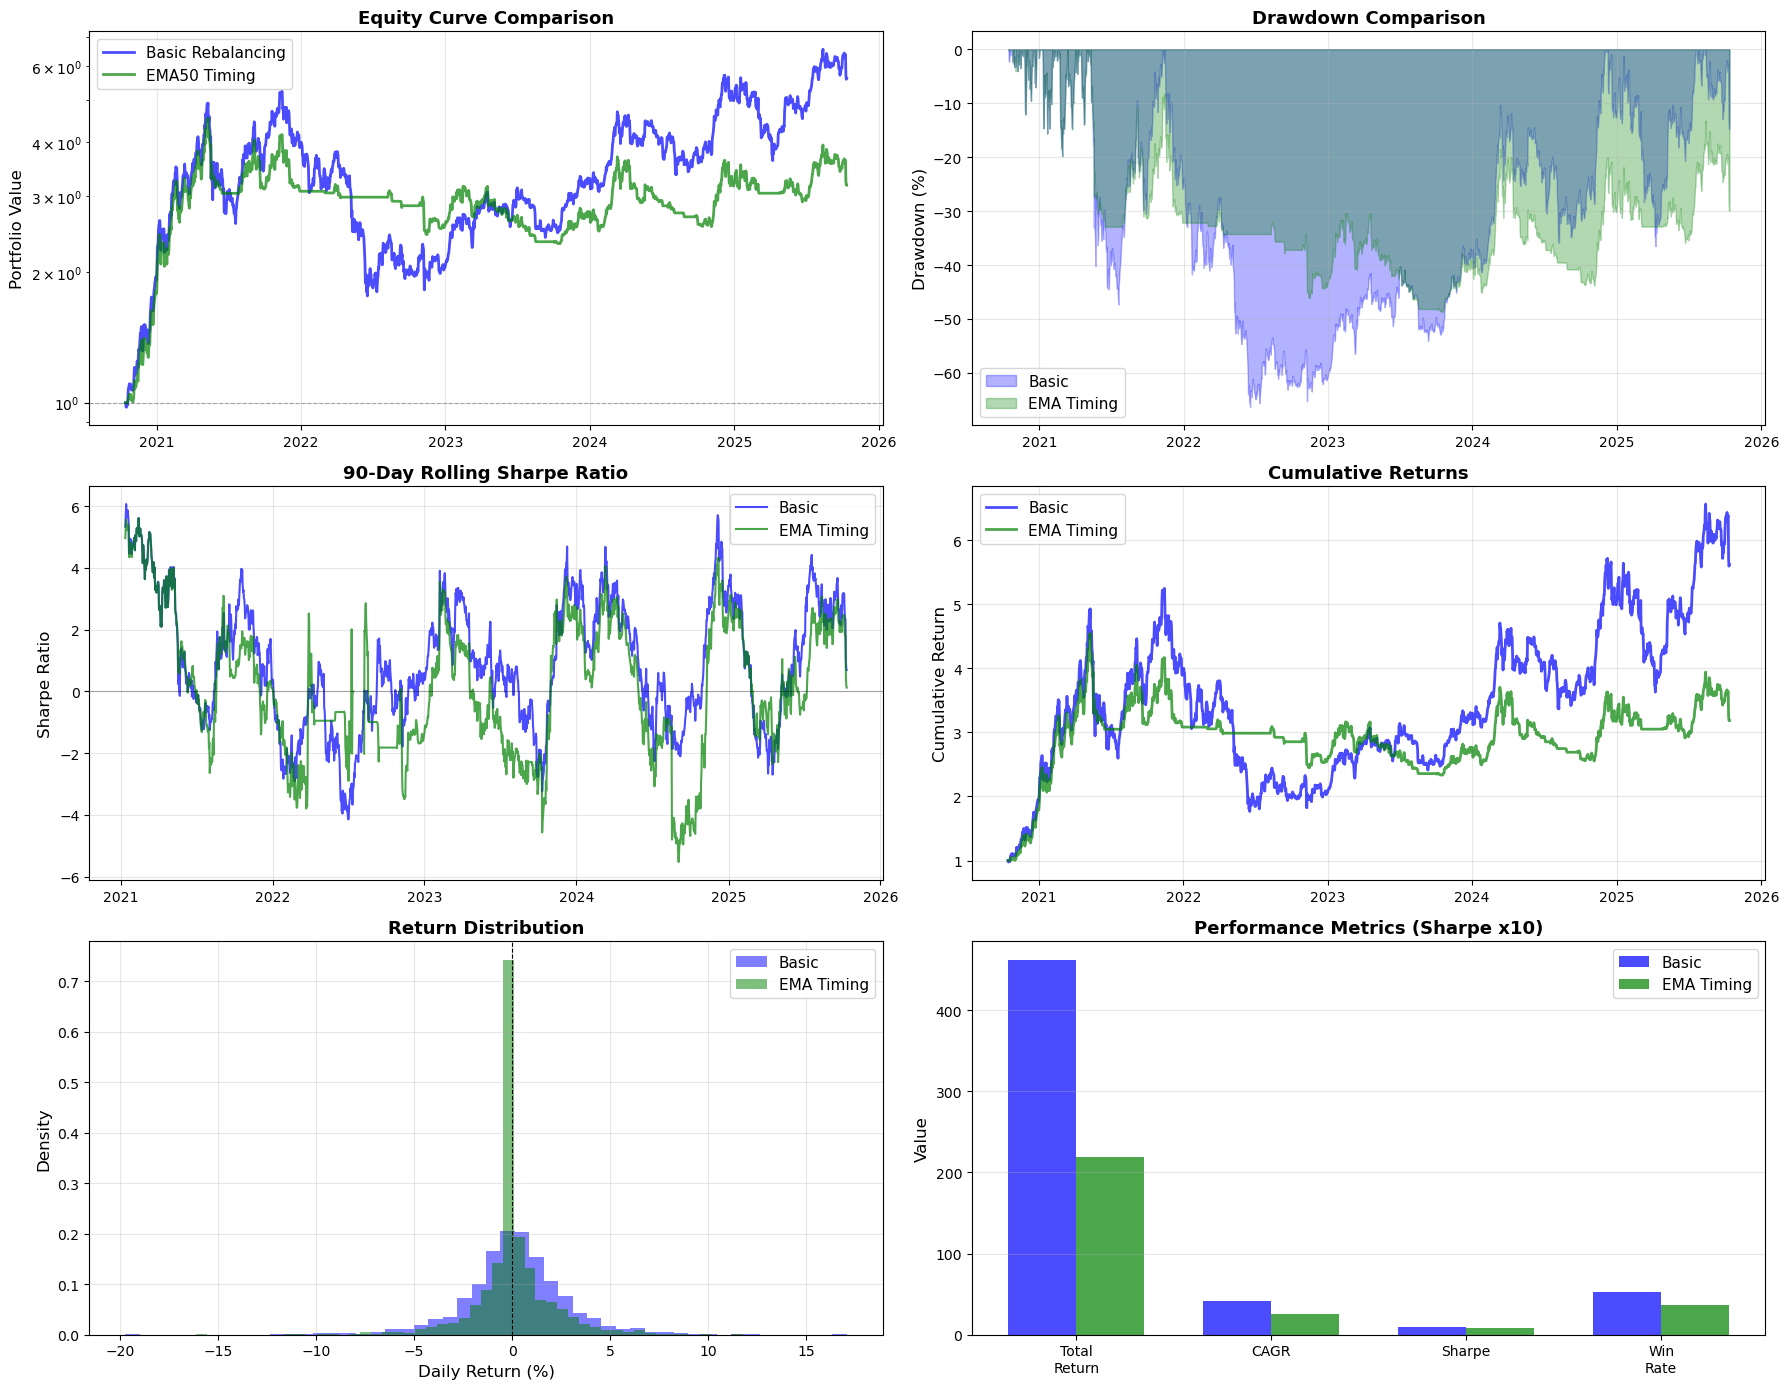


✓ EMA timing comparison complete


In [18]:
# Visualize comparison
fig, axes = plt.subplots(3, 2, figsize=(18, 14))

# Plot 1: Equity curves
ax1 = axes[0, 0]
ax1.plot(basic_equity.index, basic_equity.values, label='Basic Rebalancing', linewidth=2, color='blue', alpha=0.7)
ax1.plot(ema_equity.index, ema_equity.values, label='EMA50 Timing', linewidth=2, color='green', alpha=0.7)
ax1.axhline(y=1.0, color='black', linestyle='--', linewidth=0.8, alpha=0.3)
ax1.set_ylabel('Portfolio Value', fontsize=12)
ax1.set_title('Equity Curve Comparison', fontsize=13, fontweight='bold')
ax1.set_yscale('log')
ax1.legend(loc='best', fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 2: Drawdown comparison
ax2 = axes[0, 1]
basic_dd = (basic_equity / basic_equity.cummax() - 1) * 100
ema_dd = (ema_equity / ema_equity.cummax() - 1) * 100
ax2.fill_between(basic_dd.index, basic_dd.values, 0, alpha=0.3, color='blue', label='Basic')
ax2.fill_between(ema_dd.index, ema_dd.values, 0, alpha=0.3, color='green', label='EMA Timing')
ax2.set_ylabel('Drawdown (%)', fontsize=12)
ax2.set_title('Drawdown Comparison', fontsize=13, fontweight='bold')
ax2.legend(loc='lower left', fontsize=11)
ax2.grid(True, alpha=0.3)

# Plot 3: Rolling Sharpe (90-day)
ax3 = axes[1, 0]
basic_rolling_sharpe = basic_returns.rolling(90).mean() / basic_returns.rolling(90).std() * np.sqrt(365)
ema_rolling_sharpe = ema_returns.rolling(90).mean() / ema_returns.rolling(90).std() * np.sqrt(365)
ax3.plot(basic_rolling_sharpe.index, basic_rolling_sharpe.values, label='Basic', linewidth=1.5, alpha=0.7, color='blue')
ax3.plot(ema_rolling_sharpe.index, ema_rolling_sharpe.values, label='EMA Timing', linewidth=1.5, alpha=0.7, color='green')
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.3)
ax3.set_ylabel('Sharpe Ratio', fontsize=12)
ax3.set_title('90-Day Rolling Sharpe Ratio', fontsize=13, fontweight='bold')
ax3.legend(loc='best', fontsize=11)
ax3.grid(True, alpha=0.3)

# Plot 4: Cumulative returns
ax4 = axes[1, 1]
basic_cumret = (basic_returns + 1).cumprod()
ema_cumret = (ema_returns + 1).cumprod()
ax4.plot(basic_cumret.index, basic_cumret.values, label='Basic', linewidth=2, alpha=0.7, color='blue')
ax4.plot(ema_cumret.index, ema_cumret.values, label='EMA Timing', linewidth=2, alpha=0.7, color='green')
ax4.set_ylabel('Cumulative Return', fontsize=12)
ax4.set_title('Cumulative Returns', fontsize=13, fontweight='bold')
ax4.legend(loc='best', fontsize=11)
ax4.grid(True, alpha=0.3)

# Plot 5: Return distribution
ax5 = axes[2, 0]
ax5.hist(basic_returns * 100, bins=50, alpha=0.5, label='Basic', color='blue', density=True)
ax5.hist(ema_returns * 100, bins=50, alpha=0.5, label='EMA Timing', color='green', density=True)
ax5.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
ax5.set_xlabel('Daily Return (%)', fontsize=12)
ax5.set_ylabel('Density', fontsize=12)
ax5.set_title('Return Distribution', fontsize=13, fontweight='bold')
ax5.legend(loc='best', fontsize=11)
ax5.grid(True, alpha=0.3)

# Plot 6: Performance metrics bar chart
ax6 = axes[2, 1]
metrics = ['Total\nReturn', 'CAGR', 'Sharpe', 'Win\nRate']
basic_vals = [basic_report.total_return, basic_report.cagr, basic_report.sharpe*10, basic_report.win_rate]
ema_vals = [ema_report.total_return, ema_report.cagr, ema_report.sharpe*10, ema_report.win_rate]
x = np.arange(len(metrics))
width = 0.35
ax6.bar(x - width/2, basic_vals, width, label='Basic', alpha=0.7, color='blue')
ax6.bar(x + width/2, ema_vals, width, label='EMA Timing', alpha=0.7, color='green')
ax6.set_ylabel('Value', fontsize=12)
ax6.set_title('Performance Metrics (Sharpe x10)', fontsize=13, fontweight='bold')
ax6.set_xticks(x)
ax6.set_xticklabels(metrics)
ax6.legend(loc='best', fontsize=11)
ax6.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n✓ EMA timing comparison complete")